In [562]:
import dgl
import torch
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)


{0: Text(-0.6633663366336633, -0.3267326732673267, 'Factor 0'),
 1: Text(-0.3168316831683168, 0.019801980198019792, 'Factor 1'),
 2: Text(-0.5940594059405939, -0.25742574257425743, 'Loc 1'),
 3: Text(-0.45544554455445535, -0.1188118811881188, 'Loc 2'),
 4: Text(-0.17821782178217818, 0.1584158415841584, 'Loc 3'),
 5: Text(0.5148514851485149, 0.019801980198019792, 'Loc 4'),
 6: Text(-0.039603960396039584, 0.29702970297029696, 'Loc 5'),
 7: Text(-0.5247524752475247, -0.18811881188118812, 'Borrower 1'),
 8: Text(0.4455445544554455, -0.04950495049504951, 'Borrower 2'),
 9: Text(-0.10891089108910888, 0.22772277227722768, 'Borrower 3'),
 10: Text(0.5841584158415841, 0.08910891089108909, 'Borrower 4'),
 11: Text(0.029702970297029715, 0.3663366336633663, 'Borrower 5'),
 12: Text(0.9999999999999999, -0.3267326732673267, 'Sector 1'),
 13: Text(0.3069306930693069, 0.08910891089108909, 'Sector 2')}

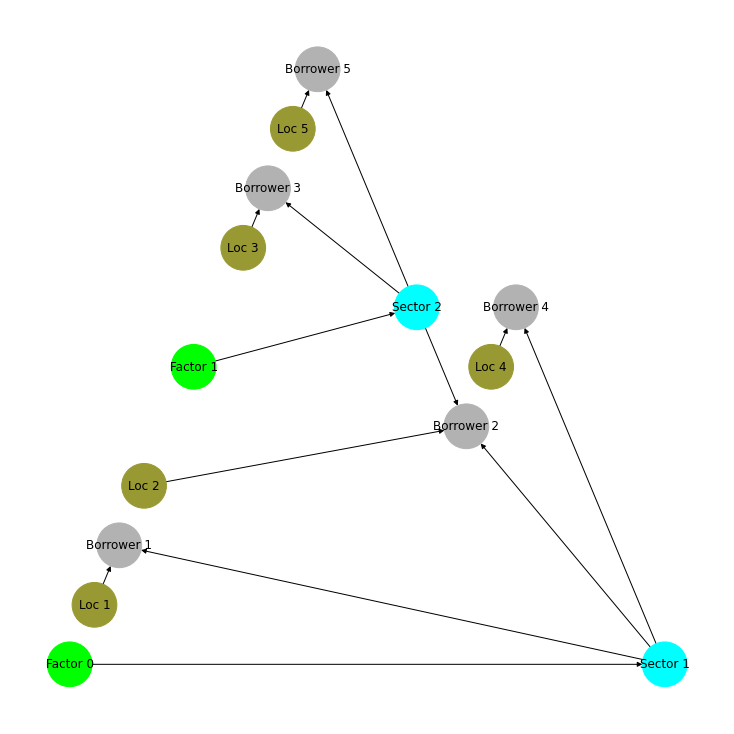

In [620]:
def build_b_s_graph():

    
    b_s_src = np.array([0,1,1,2,3,4])
    b_s_dst = np.array([0,0,1,1,0,1])
    
    data_dict = {
    ('sector', 'belongs', 'borrower'): (torch.tensor(b_s_dst), torch.tensor(b_s_src)),
        #('borrower', 'is belonged to', 'sector'): (torch.tensor(b_s_src), torch.tensor(b_s_dst)),
    #('KPI', 'depends', 'borrower'): (torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4])),
    #('Fin', 'are', 'borrower'): (torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4])),
    ('Loc', 'of', 'borrower'): (torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4])),
    ('Factor', 'is a factor', 'sector'): (torch.tensor([0,1]), torch.tensor([0,1]))
    }

    return dgl.heterograph(data_dict)

sG = build_b_s_graph()
#sG = dgl.add_self_loop(sG)
sG_homo = dgl.to_homo(sG)
snx_G = sG_homo.to_networkx()
pos = nx.planar_layout(snx_G)

codes = torch.tensor([3,3,5,5,5,5,5,0,0,0,0,0,2,2])
colors = torch.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])

labels={0:'Factor 0',1:'Factor 1',2:'Loc 1',3:'Loc 2',4:'Loc 3',5:'Loc 4',6:'Loc 5',7:'Borrower 1',
       8:'Borrower 2',9:'Borrower 3',10:'Borrower 4',11:'Borrower 5',12:'Sector 1',13:'Sector 2'}
plt.figure(figsize=(10, 10))
nx.draw(snx_G, pos, with_labels=False, node_size = 2000, node_color = colors[codes])
nx.draw_networkx_labels(snx_G, pos,labels)
#nx.draw(snx_G, pos, with_labels=True, node_color=colors[codes])

In [621]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(in_feats, hid_feats) for rel in rel_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({'belongs':dgl.nn.GraphConv(hid_feats,out_feats),
                                             'of':dgl.nn.GraphConv(hid_feats,out_feats)},
                                             aggregate='sum')
        #dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(hid_feats, out_feats) for rel in rel_names}, aggregate='sum')

        
    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        #print("layer1 : ",h)
        h = {k: F.relu(v) for k, v in h.items()}
        #print("AFter Relu : ",h)
        #h = self.conv2(graph, h)
        #print("layer 2 : ",h)
        return h
    
    
model = RGCN(5, 5, 2, sG.etypes)

In [622]:
sG.nodes['borrower'].data['feature'] = torch.tensor([[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],
[0, 0, 0, 0, 1]])

sG.nodes['Loc'].data['feature'] = torch.tensor([[0, 0, 0, 0, 1],[0, 0, 1, 1, 1],[1, 1, 1, 1, 1],[0, 0, 0, 0, 1],
[1, 1, 1, 1, 1]])

sG.nodes['Factor'].data['feature'] = torch.tensor([[0, 0, 0, 0, 1],[0, 0, 0, 0, 1]])

sG.nodes['sector'].data['feature'] = torch.tensor([[0, 0, 0, 0, 1],[0, 0, 0, 0, 1]])

# Only sectors are labeled 
#sG.nodes['sector'].data['label'] = torch.tensor([0,1])

tensor([[0.0000, 0.8094, 0.0000, 0.0000, 0.0000],
        [0.1162, 0.7773, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6897, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8094, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6897, 0.0000, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)


{0: Text(-0.6633663366336633, -0.3267326732673267, 'Factor 0'),
 1: Text(-0.3168316831683168, 0.019801980198019792, 'Factor 1'),
 2: Text(-0.5940594059405939, -0.25742574257425743, 'Loc 1'),
 3: Text(-0.45544554455445535, -0.1188118811881188, 'Loc 2'),
 4: Text(-0.17821782178217818, 0.1584158415841584, 'Loc 3'),
 5: Text(0.5148514851485149, 0.019801980198019792, 'Loc 4'),
 6: Text(-0.039603960396039584, 0.29702970297029696, 'Loc 5'),
 7: Text(-0.5247524752475247, -0.18811881188118812, 'Borrower 1'),
 8: Text(0.4455445544554455, -0.04950495049504951, 'Borrower 2'),
 9: Text(-0.10891089108910888, 0.22772277227722768, 'Borrower 3'),
 10: Text(0.5841584158415841, 0.08910891089108909, 'Borrower 4'),
 11: Text(0.029702970297029715, 0.3663366336633663, 'Borrower 5'),
 12: Text(0.9999999999999999, -0.3267326732673267, 'Sector 1'),
 13: Text(0.3069306930693069, 0.08910891089108909, 'Sector 2')}

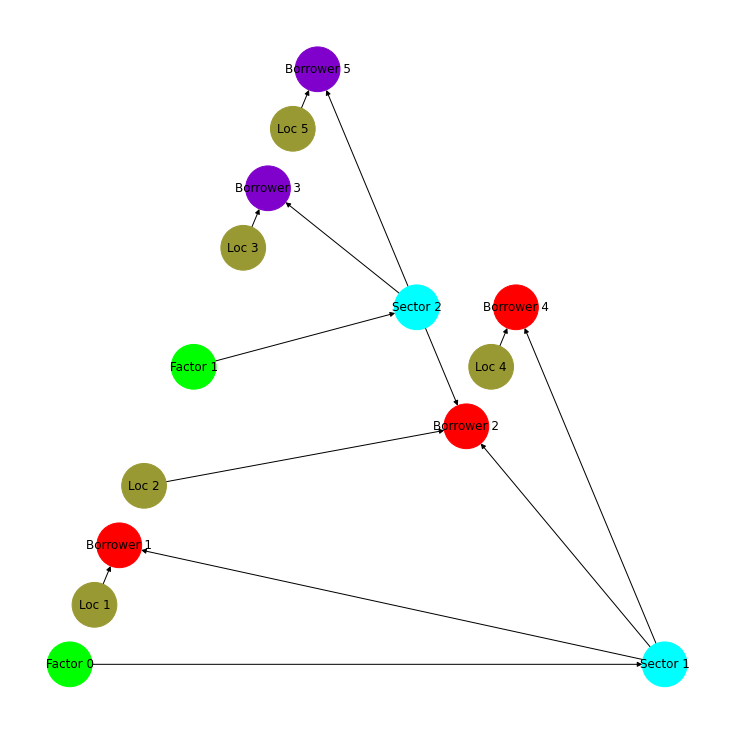

In [625]:
#model = RGCN(5, 5, 2, sG.etypes)
borrower_feats = sG.nodes['borrower'].data['feature']
sector_feats = sG.nodes['sector'].data['feature']
loc_feats = sG.nodes['Loc'].data['feature']
factor_feats = sG.nodes['Factor'].data['feature']

c_labels = torch.tensor([0,1])
labeled_borrowers = torch.tensor([0,4])

#node_features = {'borrower':borrower_feats,'sector':sector_feats,'KPI':kpi_feats, 'Fin':fin_feats,
#'Loc':loc_feats,'Factor':factor_feats}
node_features = {'borrower':borrower_feats,'Loc':loc_feats,'Factor':factor_feats,'sector':sector_feats}

opt = torch.optim.Adam(model.parameters())

for epoch in range(50):
    model.train()
    # forward propagation by using all nodes and extracting the user embeddings
    logits = model(sG, node_features)
    
    loss = F.cross_entropy(logits['borrower'][labeled_borrowers], c_labels)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
print(logits['borrower'])

X = logits['borrower'].detach().numpy()
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

prediction = torch.tensor(kmeans.predict(X)).long()
#print(prediction)

b_colors = torch.tensor([[.5,0,.8],[1,0,0]])
o_colors = torch.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])
c = torch.tensor([3,3,5,5,5,5,5])

colors = torch.cat((o_colors[c],b_colors[prediction]))
# nx.draw(snx_G, pos, with_labels=True, node_color = torch.cat((colors,o_colors[[2,2]])))


labels={0:'Factor 0',1:'Factor 1',2:'Loc 1',3:'Loc 2',4:'Loc 3',5:'Loc 4',6:'Loc 5',7:'Borrower 1',
       8:'Borrower 2',9:'Borrower 3',10:'Borrower 4',11:'Borrower 5',12:'Sector 1',13:'Sector 2'}
plt.figure(figsize=(10, 10))
nx.draw(snx_G, pos, with_labels=False, node_size = 2000, node_color = torch.cat((colors,o_colors[[2,2]])))
nx.draw_networkx_labels(snx_G, pos,labels)
#nx.draw(snx_G, pos, with_labels=True, node_color=torch.cat((colors,o_colors[[2,2]])))